# Interfacing pytorch models with anndata

**Author:** [Sergei Rybakov](https://github.com/koncopd)

This tutorial shows how to use `AnnLoader` to build pytorch models using `anndata`.

* Checkout great alternative ways to building interfaces with pytorch, for instance, in [scvi-tools](https://scvi-tools.org/).
* Here, we use the [Pyro](http://pyro.ai) framework to simplify the code for a Variational Autoencoder.

In [1]:
import gdown
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import numpy as np
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.pytorch import AnnLoader

## VAE model definition

Here we define a helper multilayer perceptron class to use it with a VAE below.

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()
        
        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)
    
    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

The following shows a graphical representation of our VAE model. It uses the unobserved latent variable `Z` and the observed batch labels `Batch` to reconstruct input data `X` and class labels `Class`. Note that the model treats `Class` as an independent variable from `X` given `Z`. 

<img src="./_static/sup_cvae.jpg" width="300px">

Here we define our model, please see the Pyro VAE tutorials for more deatils.

In [3]:
class CVAE(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.classifier = nn.Linear(latent_dim, n_classes)
        
        self.latent_dim = latent_dim
    
    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)
            
            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
    
    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

## AnnLoader initialization

Download the data

In [4]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: C:\Users\sergei.rybakov\projects\anndata-tutorials\pancreas.h5ad
100%|███████████████████████████████████████████████████████████████████████████████| 126M/126M [00:24<00:00, 5.21MB/s]


'pancreas.h5ad'

In [4]:
adata = sc.read('pancreas.h5ad')

Visualize the data using a UMAP through a Scanpy pipeline.

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


We can see that the data has strong batch effects. We want to integrate the studies using our VAE model.

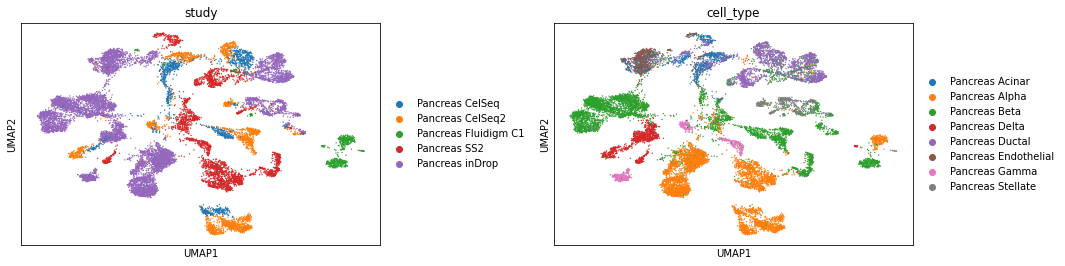

In [6]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

In [7]:
adata.X = adata.raw.X # put raw counts to .X

For our model we need size factors (library sizes) for each cell for the means of negative binomial reconstruction loss.

In [8]:
adata.obs['size_factors'] = adata.X.sum(1)

Here we set up the encoders for labels in our AnnData object. These encoders will be used by AnnLoader to convert the labels on the fly when they are accessed from the dataloader during the training phase.

In [9]:
adata.obs['study'].cat.categories

Index(['Pancreas CelSeq', 'Pancreas CelSeq2', 'Pancreas Fluidigm C1',
       'Pancreas SS2', 'Pancreas inDrop'],
      dtype='object')

In [10]:
enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc.fit(adata.obs['study'].to_numpy()[:, None])

OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False)

In [11]:
adata.obs['cell_type'].cat.categories

Index(['Pancreas Acinar', 'Pancreas Alpha', 'Pancreas Beta', 'Pancreas Delta',
       'Pancreas Ductal', 'Pancreas Endothelial', 'Pancreas Gamma',
       'Pancreas Stellate'],
      dtype='object')

In [12]:
enc_ct = LabelEncoder()
enc_ct.fit(adata.obs['cell_type'])

LabelEncoder()

In [13]:
use_cuda = torch.cuda.is_available()

You can create the converter with a function or a Mapping of functions which will be applied to the values of attributes (`.obs`, `.obsm`, `.layers`, `.X`) or to specific keys of these attributes in the subset object. Specify an attribute and a key (if needed) as keys of the passed Mapping and a function to be applied as a value.

Here we define a converter which will transform the values of the keys `'study'` and `'cell_type'` of `.obs` using the encoders created above.

In [14]:
convert = {
    'obs': {
        'study': lambda s: enc.transform(s.to_numpy()[:, None]),
        'cell_type': enc_ct.transform
    }
}

Here we create an AnnLoader object which will return a PyTorch dataloader properly set for our AnnData object. 

The `use_cuda` parameter indicates that we want to lazily convert all numeric values in the AnnData object. By lazy conversion we mean that no data is converted until you access it. The AnnLoader object creates a wrapper object from the provided AnnData object and it takes care about subsetting and conversion. No copying of the full AnnData object happens here.

The converters passed to `convert` are applied before sending anything to cuda.

In [15]:
dataloader = AnnLoader(adata, batch_size=128, shuffle=True, convert=convert, use_cuda=use_cuda)

This is the wrapper object mentioned above. The dataloader itetarates through this object.

In [16]:
dataloader.dataset

AnnCollection object with n_obs × n_vars = 15681 × 1000
  constructed from 1 AnnData objects
    view of obsm: 'X_pca', 'X_umap'
    obs: 'batch', 'study', 'cell_type', 'size_factors'

Note that if `use_cuda=True`, then all numeric values will be converted to tensors and sent to cuda, so you don't need to do any conversion during the training phase.

`view of obsm` means that the wrapper object doesn't copy anything from .obsm of the underlying AnnData object. `obs` insted of `view of obs` means that the object copied .obs from the AnnData object. You can configure what is copied, please see the AnnCollection tutorial for deatils. The wrapper object (AnnCollection) never copies the full .X or .layers from the underlying AnnData object, all conversions happen when the AnnCollection object is subset.

In [29]:
dataloader.dataset[:10]

AnnCollectionView object with n_obs × n_vars = 10 × 1000
    obsm: 'X_pca', 'X_umap'
    obs: 'batch', 'study', 'cell_type', 'size_factors'

Note that the numeric values in a subset is already converted and sent to cuda (if needed).

In [18]:
batch = dataloader.dataset[:10]

print('X:', batch.X.device, batch.X.dtype)
print('X_pca:', batch.obsm['X_pca'].device, batch.obsm['X_pca'].dtype)
print('X_umap:', batch.obsm['X_umap'].device, batch.obsm['X_umap'].dtype)
# and here you can see that the converters are applied to 'study' and 'cell_type'.
print('study:', batch.obs['study'].device, batch.obs['study'].dtype)
print('cell_type:', batch.obs['cell_type'].device, batch.obs['cell_type'].dtype)

X: cuda:0 torch.float32
X_pca: cuda:0 torch.float32
X_umap: cuda:0 torch.float32
study: cuda:0 torch.float32
cell_type: cuda:0 torch.int32


You can also use a custom sampler instead of the default one with automatic bacthing in `AnnLoader`. Just pass your `sampler` and `batch_size`.

In [19]:
from torch.utils.data import WeightedRandomSampler

In [24]:
weights = np.ones(adata.n_obs)
weights[adata.obs['cell_type'] == 'Pancreas Stellate'] = 2.
sampler = WeightedRandomSampler(weights, adata.n_obs)

In [25]:
dataloader = AnnLoader(adata, batch_size=128, sampler=sampler, convert=convert, use_cuda=use_cuda)

We don't use the custom sampler for training the model, so return to the default sampler here.

In [28]:
dataloader = AnnLoader(adata, batch_size=128, shuffle=True, convert=convert, use_cuda=use_cuda)

## Initialize and train the model

Here we initialize the model and the Pyro routines for training.

In [20]:
n_conds = len(adata.obs['study'].cat.categories)
n_classes = len(adata.obs['cell_type'].cat.categories)
cvae = CVAE(adata.n_vars, n_conds=n_conds, n_classes=n_classes, hidden_dims=[128, 128], latent_dim=10)

if use_cuda:
    cvae.cuda()

In [21]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO())

Here is the code for our training phase. The AnnLoader object is passed as a dataloader, it iterates through `dataloader.dataset` (as in a standard PyTorch dataloader).

Note that now you can simply take a batch from the dataloader, select a required attribute, do something with it if needed and pass to your loss function. Everything is already converted by the pre-defined converters. You don't need to copy your AnnData object, you don't need a custom dataloader for a dictionary of required keys, all observation keys are already in the bacthes.

In [22]:
def train(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        epoch_loss += svi.step(batch.X, batch.obs['study'], batch.obs['cell_type'], batch.obs['size_factors'])

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [23]:
NUM_EPOCHS = 210

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 40 == 0 or epoch == NUM_EPOCHS-1:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 1247.6794
[epoch 040]  average training loss: 697.4832
[epoch 080]  average training loss: 687.4089
[epoch 120]  average training loss: 684.2322
[epoch 160]  average training loss: 682.4246
[epoch 200]  average training loss: 681.2204
[epoch 209]  average training loss: 680.9141


## Check the results

In [24]:
full_data = dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [25]:
means = cvae.encoder(full_data.X, full_data.obs['study'])[:, :10] # get mean values of the latent variables

In [26]:
adata.obsm['X_cvae'] = means.data.cpu().numpy()

In [27]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

The results of the study integration using our VAE model.

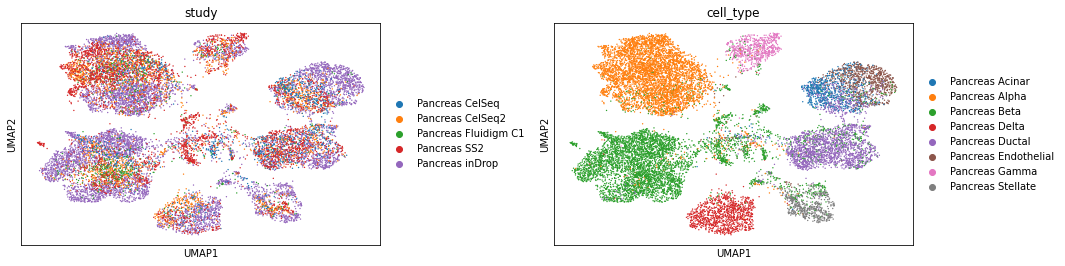

In [28]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

In [29]:
accuracy = (cvae.classifier(means).argmax(dim=-1)==full_data.obs['cell_type']).sum().item()/adata.n_obs

In [30]:
accuracy

0.9201581531790064